# Customer purchase segmentation and retention prediction 
## Business case
ColModa S.A. is a clothing retail company that distribute SuperDry and Diesel across 50 stores in 18 regions of Colombia and online platform. They wanted to gain deper understanding of their customer retention from promotion campaigns and purchase patterns to strategize their new customized marketing efforts to maximize customer retention. This could be an additional efforts beside the foot traffic of physical stores to attract more customer post-COVID, since their online platforms have thrived since.
This report use the first purchase detail of new customer from the first six months of 2022 and track if they return till May, 2023.

## Goals
The first goal is to define customer segmentation based on their purchase details like total amount, quantity and purchase items of customers in 2 purchase channels: physical and online. We will employ clustering learning technique in this matter.

The second goal is to point out which aspect are most important to predict customer retention. Combining these insights could help on-site sales team to make efforts to maximize their retention. Several classification models and ensemble methods would be explored to maximize prediction performance and intepretation.

The report will dive into exploratory analysis to catch any significant trends and futher expand or adjust the report scope, then perform clustering technique to add more labels and categories to data to feed into predictive models later.
In the end, the report would recommend an actionable plan for marketing team based on the findings.

## Findings
After performing clustering, we found 4 segments of purchase behavior:
- almost two third of the their new customers buy single low-price item that are on sale, contributing about a third of revenue with the highest amount of discount usage, 20\%.
- a quarter of their new customer buy slightly more in quantity than the first group but with higher-price items, contributing more than a third of revenue while only use around 10\% of the discount.
- the last two groups are accountable for less than 8% of the new customer base, but generate more than a quarter of revenue. 
>- the third popular group buy around 3 high-value items in multiple categories while using only 10\% discount. 
>- the last group is only 1% of the population with extremely high in quantity and varieties while utilizing only around 5\% of discount. 

However, the report found no strong evidence of any significant predictors in customer retention, thus disregarding the machine learning models. 

## Recommendation
Although the report could not find any good information on retention, the report suggest some customized sale effort to maximize revenue. The sales team should consider cross-sale strategies to customers that are interested in sale items only, to maximize the revenue from the first group with low purchase value, since this is the company's largest customer base. Since they came in being price consious, the sales team could recommend items in low-price ranges that compliment the item they came in for, or some essential accessories.


## Dataset Introduction
The analyst extracted from company analytical database using SQL and allowed me to work on this project. The raw data combines granular information of single item per each purchase, and each purchase belongs to 1 customer. So the data would be aggregated to the point where each customer would have only 1 record with all characteristic of their first purchase.
Some data would be elimininated if they found lack of consistency or accuracy, or presence like : DOB
The desired dataset consist of masked customer purchase details (without any identifying customer information):

- Total Amount
- Discount Amount
- Quantity
- Store
- Region
- Customer Gender
- Item Gender
- Customer Date of Birth
- Retention indicator

In [1]:
# Import all libraries

import numpy as np
import pandas as pd
import datetime

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier as rf, GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression

# processing, reports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder


# Data Extraction and Cleaning

In [2]:
# Import file from Github into notebook
import urllib.request

url = 'https://raw.githubusercontent.com/tuananhnguyen527/Retail_Orders/main/Retails.txt'
with urllib.request.urlopen(url) as file:
    full_raw = file.read().decode('utf-8', errors='ignore')

In [3]:
# Split into columns and rows: rows by \n (new rows), and columns by tab (\t), stripping all unnessesary
full_row = full_raw.split("\n")
sample_list = []
for row in full_row:
    sample_list.append(row.strip().split("\t"))
    
# Convert into PD DataFrame
data_raw = pd.DataFrame(sample_list[1:], columns = sample_list[0])
data_raw

,Date_Purchase,Id_purchase,Id_client,Date_of_birth,Sex_client,Store,Region,Canal,Gender,Type_purchase,Quantity,Discount,Pay,Second_purchase
0,5/15/2022 0:00,FFQ-1617,0.1071163146,NULL,F,196,BOGOTA,Superdry,MASCULINO,CHAQUETA,1,0,449900,0
1,2/27/2022 0:00,FPE-521,53709,NULL,M,606,MEDELLIN,Superdry,FEMENINO,BUZO,1,0,299900,0
2,2/27/2022 0:00,FPE-521,53709,NULL,M,606,MEDELLIN,Superdry,FEMENINO,SANDALIAS,1,0,139900,0
3,2/27/2022 0:00,FPE-521,53709,NULL,M,606,MEDELLIN,Superdry,FEMENINO,BUZO,1,0,249900,0
4,2/27/2022 0:00,FPE-521,53709,NULL,M,606,MEDELLIN,Superdry,MASCULINO,ROPA INTERIOR,1,0,169900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30318,2/14/2022 0:00,FPE-593,yc225325,NULL,No Informado,402,BARRANQUILLA,Diesel,MASCULINO,GORRO,1,0,299900,0
30319,2/14/2022 0:00,FPE-593,yc225325,NULL,No Informado,402,BARRANQUILLA,Diesel,MASCULINO,BUZO,1,0,699900,0
30320,6/4/2022 0:00,FPE-1875,Z4814358,NULL,M,414,MEDELLIN,Diesel,MASCULINO,JEAN,1,0,699900,0
30321,6/4/2022 0:00,FPE-1875,Z4814358,NULL,M,414,MEDELLIN,Diesel,MASCULINO,POLO,1,75613,359920,0


In [4]:
# Filter bad data if applicable: misisng final pay.
data = data_raw[data_raw['Pay'] != None]

# Check Null
data_raw.isnull().sum()

# Drop that 1 row with full Null
data = data.dropna(how = 'all')
data = data[~data['Id_purchase'].isnull()]

In [5]:
# Check cardinarlity of each column. This step to see if IDs or unique values are matching and any potential duplicates. 
for column in data.columns:
    unique_values = data[column].nunique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'Date_Purchase': 181
Unique values in column 'Id_purchase': 8521
Unique values in column 'Id_client': 17430
Unique values in column 'Date_of_birth': 5399
Unique values in column 'Sex_client': 3
Unique values in column 'Store': 51
Unique values in column 'Region': 18
Unique values in column 'Canal': 2
Unique values in column 'Gender': 5
Unique values in column 'Type_purchase': 32
Unique values in column 'Quantity': 7
Unique values in column 'Discount': 863
Unique values in column 'Pay': 1004
Unique values in column 'Second_purchase': 2


Concerns:
- The database supposed to have the same number of ID_purchase and Id_client, due to the assumption of first orders of clients. This could contaminate the final result of the data set.

In [6]:
# Change data into their supposed data types
data['Date_Purchase'] = pd.to_datetime(data['Date_Purchase'])
data['Date_of_birth'] = pd.to_datetime(data['Date_of_birth'], errors='coerce')
data['Gender'].replace({'FEMENINO': 'Female', 'MASCULINO': 'Male', 'NO APLICA': 'None', 'UNISEX': 'Unisex', 'NIÑO': 'Kid'}, inplace = True)
data['Type_purchase'].replace({'CAMISETA': 'T-Shirt', 'BUZO': 'Hoodie', 'TENIS': 'Sneaker', 'CHAQUETA': 'Jacket'\
                              , 'JEAN': 'Jean', 'NO APLICA': 'None Applicable', 'MORRAL': 'Bag'\
                              ,'GORRO': 'Cap', 'POLO':'Polo Shirt', 'ROPA INTERIOR': 'Underwear', 'SANDALIAS': 'Sandals'\
                              ,'CAMISA': 'Shirt','SUDADERA': 'Hoodie', 'FRAGANCIA': 'Fragrance', 'BOLSO': 'Handbag'\
                              ,"BILLETERA": 'Wallet', 'RELOJ': 'Watch', 'PANTALON': 'Pants', 'TARJETA REGALO': 'Gift Card'\
                              ,"VESTIDO": 'Dress', 'CORREA': 'Belt', 'ZAPATOS': 'Shoes', 'MEDIAS': 'Socks'\
                              ,'FALDA': 'Skirt', 'ENTERIZO': 'Jumpsuit', 'GAFAS': 'Eye Glasses'\
                              , 'BERMUDA': 'Sweatshirt', 'ROPA DE BAÑO': 'Swimsuit', 'ESTUCHE': 'Case'\
                              }, inplace = True)
data['Second_purchase'].replace({'0': 'One-time', '1': 'Returning'}, inplace = True)
data['Quantity'] = data['Quantity'].astype(int)
data['Discount'] = data['Discount'].astype(float)

In [7]:
# Packaging items are eliminated.
data = data[~data['Type_purchase'].isin(['MATERIAL DE EMPAQUE', 'MATERIAL PUBLICITARIO', 'PROTECCION'])]

In [8]:
# Some DOB and date of purchase are similar which is impossible. 
data.loc[data['Date_of_birth'] == data['Date_Purchase'], "Date_of_birth"] = np.nan

In [9]:
usd_cop_rate = 4257.6765
data[['Discount','Pay']] = data[['Discount','Pay']].apply(lambda x: x.astype(float) / usd_cop_rate)

In [10]:
data.loc[data['Date_of_birth'].dt.year <1900, 'Date_of_birth'] = data.loc[data['Date_of_birth'].dt.year <1900, 'Date_of_birth']\
+ pd.DateOffset(years = 100)
data['Age'] = datetime.datetime.now().year - data['Date_of_birth'].dt.year 

In [11]:
# Many customer dont shop with their Info. Reasonable for missing information, not a bad pattern.
# Age of some customers are below 10. After investigation, seems like input person put DOB as same date of purchase or some date earlier.
# Remove all age below 10 to null, change all null to 0 for RF
data.loc[data['Age'] <10, 'Age'] = None
data.loc[data['Age'].isnull(), 'Age'] = 0

#Change float values of Age to int
data.loc[:,'Age'] = data['Age'].apply(lambda x: int(x))

In [12]:
data['Date_of_birth'].count()

14

Concern:
- Many DOB are similar or close to Date of Purchase, so the validation for customer age would be larger than 10.
- Many year in DOB is lower than 1900, which is humanly impossible.
These two problems could raise a concern of human 

In [13]:
data = data.drop(['Date_of_birth', 'Id_purchase', 'Date_Purchase', 'Age'], axis = 1)

## Aggregaing purchase numerical variables

This table would aggregate all numerical information of customer first purchase, preparing for customer purchase analysis with most common aggregation like count numbers or total value (sum). If this analysis still not yield good returns then manymore dimensions would be added, like Purchase_type one-hot encoded, gender one-hot encoded, ...
The table also include information that are distinct.
Aggregation details:

_ Region, store, Id_client, sex_client: distinct

_ Pay, Discount: sum

_ Gender_Product, Type_Purchase: Count distinct

_ Quantity: Sum

In [14]:
# Define custom function to calculate distinct values
def distinct(x):
    return x.unique()

# Define custom function to count distinct values
def count_distinct(x):
    return len(x.unique())

## Exploratory Data Analysis at Client level

Quick look at numerical and propotion of first purchase aggregation information. The report would shows some descriptive summary of variables related to retention rate.

In [15]:
firstpurchase_summary = data.groupby(['Id_client']).agg(client_sex = ('Sex_client', distinct)
                             ,store = ('Store', distinct)
                             ,region = ('Region', distinct) 
                             ,total_purchase = ('Pay', sum)
                             ,discount = ('Discount', sum)
                             ,product_gender_count = ('Gender', count_distinct) 
                             ,product_type_count = ('Type_purchase', count_distinct)
                             ,quantity = ('Quantity', sum)
                             ,returning = ('Second_purchase', distinct)                         
                             ).reset_index()
#firstpurchase_summary = firstpurchase_summary[~firstpurchase_summary['returning'].isin(["['Returning' 'One-time']","['One-time' 'Returning']"])]
firstpurchase_summary['returning'] = firstpurchase_summary['returning'].astype(str)
firstpurchase_summary['region'] = firstpurchase_summary['region'].astype(str)
firstpurchase_summary['store'] = firstpurchase_summary['store'].astype(str)


In [16]:
store_return = pd.crosstab(columns = firstpurchase_summary['returning'],
                           index=[firstpurchase_summary['region']])
store_return['Return_ratio'] = store_return['Returning'] / (store_return['Returning'] + store_return['One-time'])
# Return ratio on stores
store_return.sort_values('Return_ratio', ascending = False)

returning,One-time,Returning,['Returning' 'One-time'],Return_ratio
region,,,,
ONLINE,984,1102,0,0.528284
IPIALES,105,85,0,0.447368
BELLO,739,530,0,0.417652
ENVIGADO,434,283,0,0.394700
MANIZALES,215,133,0,0.382184
SABANETA,719,421,0,0.369298
BUCARAMANGA,115,66,0,0.364641
MEDELLIN,2361,1214,0,0.339580
CHIA,123,60,0,0.327869


Concern: The data include some clients that have purchased in 2 regions instead of being distinct. This could be a huge integrity of the whole dataset, but for the educational purposes of this project, those errors would be removed to maintain the assumption that the aggregation only have distinctive details of first purchase per customer.

In [17]:
#Filter out the bad ID
firstpurchase_summary = firstpurchase_summary[~firstpurchase_summary['Id_client'].isin(['104987680', '1020746710', '80048159'])]

The majority of people who purchase online will returns, while people using brick&mortal channels have lower chances. 
Since the two buying channels might have underlying customer behaviors, theyshould be analyzed seperatedly.

In [18]:
store_firstpurchase_summary = firstpurchase_summary[firstpurchase_summary['region'] != 'ONLINE']

In [19]:
store_return = pd.crosstab(columns = store_firstpurchase_summary['returning'],
                           index=[store_firstpurchase_summary['region']])
store_return['Return_ratio'] = store_return['Returning'] / (store_return['Returning'] + store_return['One-time'])
# Return ratio on stores
store_return.sort_values('Return_ratio', ascending = False)

returning,One-time,Returning,Return_ratio
region,,,
IPIALES,105,85,0.447368
BELLO,739,530,0.417652
ENVIGADO,434,283,0.394700
MANIZALES,215,133,0.382184
SABANETA,719,421,0.369298
BUCARAMANGA,115,66,0.364641
MEDELLIN,2360,1214,0.339675
CHIA,123,60,0.327869
SANTANDER,359,167,0.317490


The retention rate varies from 15.8% to 44.7%, with Ipiales and Bello are the two of highest retention with over 40% while the lowest performing group in retention consist of Cartagena, Neiva, Cucuta with less then 22%.

In [20]:
clientsex_return = pd.crosstab(store_firstpurchase_summary['client_sex'],store_firstpurchase_summary['returning'])
clientsex_return['Return_ratio'] = clientsex_return['Returning'] / (clientsex_return['Returning'] + clientsex_return['One-time'])
clientsex_return

returning,One-time,Returning,Return_ratio
client_sex,,,
F,2705,1284,0.321885
M,4158,2126,0.338320
No Informado,3482,1546,0.307478


The information on customer gender does not have a large variances, ranging from 30% to 33.8% between all gender. This might not be the important factor.

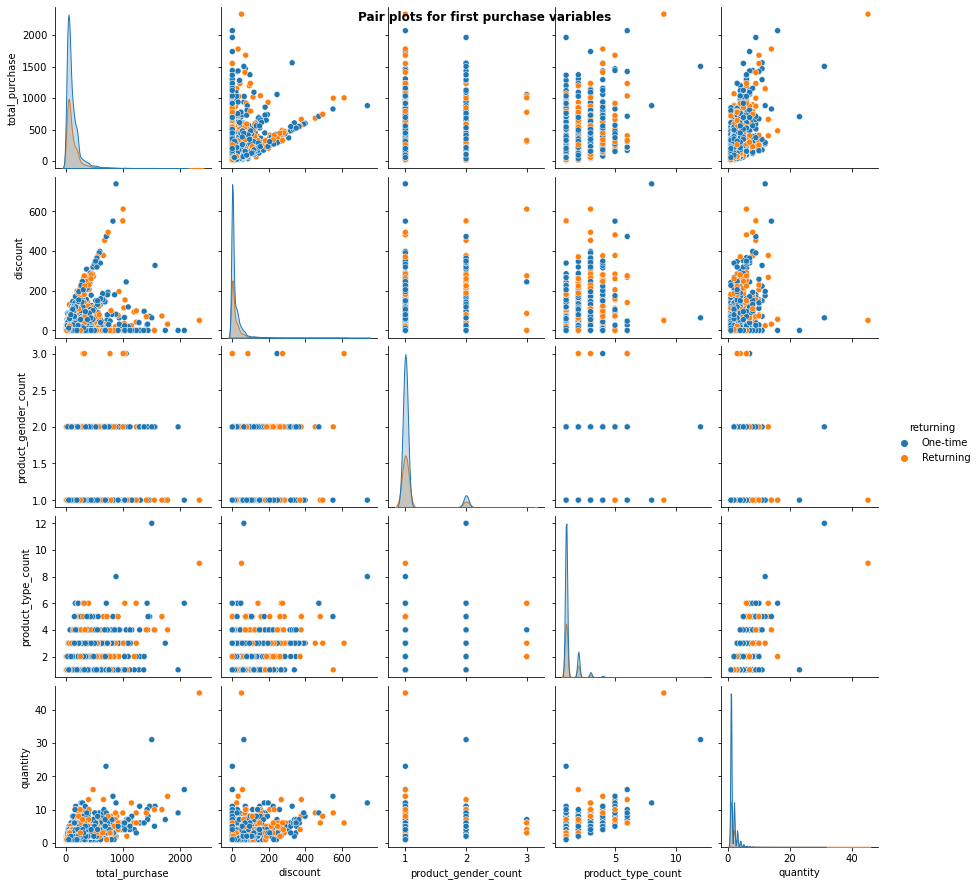

In [21]:
sns.pairplot(store_firstpurchase_summary, hue = 'returning', hue_order = ['One-time', 'Returning'])
plt.suptitle('Pair plots for first purchase variables', fontweight = 'bold')
plt.show()

No strong linear patterns have been picked out from looking at the pair plots.

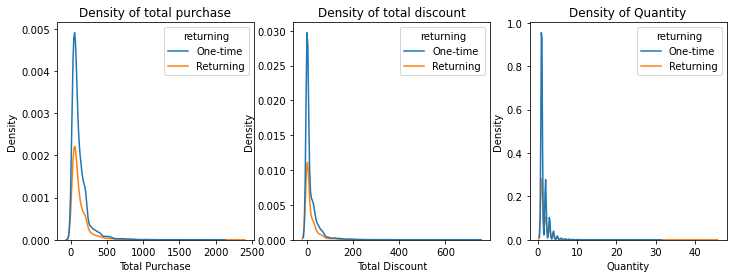

In [22]:
fig,axes = plt.subplots(1,3,figsize = (12,4))

sns.kdeplot(ax = axes[0], data=store_firstpurchase_summary, x ='total_purchase', hue = 'returning')
axes[0].set_xlabel('Total Purchase')
axes[0].set_ylabel('Density')
axes[0].set_title('Density of total purchase')

sns.kdeplot(ax = axes[1], data=store_firstpurchase_summary, x ='discount', hue = 'returning')
axes[1].set_xlabel('Total Discount')
axes[1].set_ylabel('Density')
axes[1].set_title('Density of total discount')

sns.kdeplot(ax = axes[2], data=store_firstpurchase_summary, x ='quantity', hue = 'returning')
axes[2].set_xlabel('Quantity')
axes[2].set_ylabel('Density')
axes[2].set_title('Density of Quantity')

plt.show()

In [23]:
store_firstpurchase_summary['total_purchase'].describe()

count    15301.000000
mean       120.984622
std        133.543157
min          5.860004
25%         45.764398
50%         76.950186
75%        152.641940
max       2331.229251
Name: total_purchase, dtype: float64

In [24]:
store_firstpurchase_summary['discount'].describe()

count    15301.000000
mean        16.903794
std         36.322502
min          0.000000
25%          0.000000
50%          0.000000
75%         22.097498
max        739.031018
Name: discount, dtype: float64

In [25]:
store_firstpurchase_summary['quantity'].describe()

count    15301.000000
mean         1.610222
std          1.247360
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         45.000000
Name: quantity, dtype: float64

## Clustering customer purchases using unsupervised learning
Here we add some unsupervised learning models to cluster the customer purchase behaviors through their numerical purchase values like total amount or discount


In [26]:
from sklearn.cluster import KMeans as kmeans

In [27]:
store_firstpurchase_summary

,Id_client,client_sex,store,region,total_purchase,discount,product_gender_count,product_type_count,quantity,returning
0,0.1071163146,F,196,BOGOTA,105.667962,0.000000,1,1,1,One-time
1,0011417503-7,No Informado,406,BOGOTA,352.257857,0.000000,1,1,2,One-time
2,0011486158-6,F,618,BOGOTA,70.437479,0.000000,1,1,1,One-time
3,001160587310-6,No Informado,413,MEDELLIN,587.057283,0.000000,1,3,5,One-time
4,0011630604-4,M,414,MEDELLIN,540.153767,0.000000,1,1,2,One-time
...,...,...,...,...,...,...,...,...,...,...
17385,x2821734,No Informado,609,ENVIGADO,60.554154,5.324970,1,1,2,Returning
17386,xde069361,M,607,MEDELLIN,93.924468,78.928261,1,2,2,One-time
17387,y00059208,M,407,BOGOTA,56.349983,11.838147,1,1,1,One-time
17388,y02167p3199,No Informado,426,BOGOTA,199.615917,0.000000,1,1,1,One-time


C:\Users\tuana\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tuana\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tuana\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tuana\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tuana\anaconda3\lib\site-packages\sklearn\clust

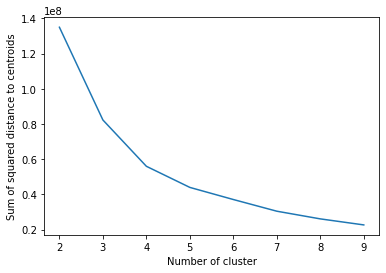

In [28]:
# filter the numerical values

numval = store_firstpurchase_summary[['total_purchase', 'discount', 'product_gender_count', 'product_type_count', 'quantity']]

#cluster number from 2 to 10
clus_num = range(2,10)
inertias = []
for clus in clus_num:
    model = kmeans(n_clusters = clus, random_state = 527)
    model.fit(numval)
    inertias.append(model.inertia_)
    
# Plot the k numbers of clusters and correspond total distance to centroid
plt.plot(clus_num, inertias)
plt.xlabel('Number of cluster')
plt.ylabel('Sum of squared distance to centroids')
plt.show()

As we see in the plot above, the sum of squared distance reduce rapidly until 4 clusters. 4 clusters would be used to describe this dataset

In [29]:
# Perform K-means clustering
model = kmeans(n_clusters= 4, random_state= 527)
cluster_labels = model.fit_predict(numval)

# Get cluster centers
cluster_centers = model.cluster_centers_

# Get cluster sizes (number of samples in each cluster)
cluster_sizes = np.bincount(cluster_labels)

# Assign cluster labels to the numval dataset
numval['Cluster'] = cluster_labels

# Group by cluster and calculate summary statistics
cluster_summary = numval.groupby('Cluster').agg(['mean']).merge(numval.groupby('Cluster')[['discount']].count(), left_index = True, right_index = True)
cluster_summary.columns = ['Total Purchase Centroid', 'Discount Centroid', 'Product Gender Count Centroid', 'Product Type Centroid', 'Quantity Centroid', 'Count']


C:\Users\tuana\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tuana\AppData\Local\Temp/ipykernel_21080/2382074046.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numval['Cluster'] = cluster_labels
C:\Users\tuana\anaconda3\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


In [49]:
# Add some more metrics to the summary: Discount/ Purchase, Population propotion, Group value
cluster_summary['Discount propotion'] = cluster_summary['Discount Centroid'] / cluster_summary['Total Purchase Centroid']
cluster_summary['Count propotion'] = cluster_summary['Count']/ len(numval)
cluster_summary['Cluster total purchase'] = (cluster_summary['Total Purchase Centroid'])* cluster_summary['Count']

# Print the summary
cluster_summary.sort_values('Count', ascending = False)

,Total Purchase Centroid,Discount Centroid,Product Gender Count Centroid,Product Type Centroid,Quantity Centroid,Count,Discount propotion,Count propotion,Cluster total purchase,Cluster total revenue
Cluster,,,,,,,,,,
0,58.909816,12.603280,1.046265,1.116644,1.335522,10202,0.213942,0.666754,600997.941248,600997.941248
2,179.786399,19.461865,1.120239,1.384118,1.841673,4017,0.108250,0.262532,722201.965086,722201.965086
1,414.145319,46.623358,1.297964,1.787781,2.929260,933,0.112577,0.060976,386397.582343,386397.582343
3,950.256479,56.297916,1.402685,2.724832,5.919463,149,0.059245,0.009738,141588.215309,141588.215309


The cluster centroids using mean of the values shows that we have 4 clusters, which number 3 and 2 are the most crowded with 10,187 and 4,009 observations while number 0 and 1 only have 946 and 159 respectively. The first two clusters compose more than 90% of the population, with the cluster 0 dominate in number with 66.6%.
- The most popular cluster, number 3, have the lowest values in almost every values except Discount propotion. Their purchase values is only \$58.8 with low quantity 1.3 units and almost in 1 product type while they utilize 21.4\% in discount.
- The second common cluster is the number 2, with total value \$178, almost triple the cluster number 3 while only using 10% of the discount. Averagely, they tends to buy multiple items but their carts are not that various in product types.
- The cluster number 0 represents only 6% of the customers, with average purchase of \$414, almost double the previous group while using reletively similar discount propotion with the previous group. They tends to buy about 3 pieces of garments in 2 product types.
- The last cluster, number 1, is significantly small, less than 1\% of the population, but pays the marginally large amount, average \$950 using only 5% of discount, with 6 items in almost 3 product types.

Although the customers in group 0 and 1 contribute significantly more than the most popular group, around 8 to 15 times higher in individual purchases, cluster 3 and 2 contribues the most sales to the company, 600,997 and \$722,201$ compared to only more than \$500,000 of the remain groups.

In [31]:
# Check the retention rate of each cluster
retention_cluster = pd.crosstab(cluster_labels, store_firstpurchase_summary['returning'])
retention_cluster['returning_rate'] = retention_cluster['Returning'] / (retention_cluster['Returning'] + retention_cluster['One-time'])
retention_cluster

returning,One-time,Returning,returning_rate
row_0,,,
0,6903,3299,0.323368
1,626,307,0.329046
2,2718,1299,0.323376
3,98,51,0.342282


The returning rate of each clusters are relatively the same, around 32% to 34%, showing no dominance or clear patterns or each customer groups in retention.

After looking at the customer clusters and their collective contribution to the company, the cluster number 2 is clearly the best cluster constituting 40% of the whole group revenues with customer buy low quantity of high value items. The running up is cluster number 2 with low-value purchases, almost single items with 20% usage of discount, but accounts for 30% of revenue and about two third of customer base.

# Retention prediction using classification methods
In this section, the report utilizes multiple classification methods with their default hyperparameters and intepret the findings of the best performance.

First, the report adds information about customer cart's items into the dataset. Then, 30% of the dataset would be keep out as an evaluation set while using 70% to train the predictive models. To compare the models, the report not only focus on overall accuracy of the model, but looking at the rententive group prediction precision as well.

#### Create one-hot code for cart items

In [32]:
one_hot_encoded_producttype = pd.get_dummies(data['Type_purchase'])
# Concatenate the one-hot encoded columns with the original DataFrame
data_encoded = pd.concat([data, one_hot_encoded_producttype], axis=1)

# Optionally, drop the original categorical column
data_encoded.drop('Type_purchase', axis=1, inplace=True)

In [33]:
data_encoded = data_encoded.iloc[:, [0] + list(range(10, len(data_encoded.columns)))]

In [34]:
product_list = data_encoded.groupby('Id_client').sum()

In [35]:
store_firstpurchase_summary = store_firstpurchase_summary.merge(product_list, left_on = 'Id_client', right_on = 'Id_client')

In [36]:
store_firstpurchase_summary

,Id_client,client_sex,store,region,total_purchase,discount,product_gender_count,product_type_count,quantity,returning,...,Shirt,Shoes,Skirt,Sneaker,Socks,Sweatshirt,T-Shirt,Underwear,Wallet,Watch
0,0.1071163146,F,196,BOGOTA,105.667962,0.000000,1,1,1,One-time,...,0,0,0,0,0,0,0,0,0,0
1,0011417503-7,No Informado,406,BOGOTA,352.257857,0.000000,1,1,2,One-time,...,0,0,0,0,0,0,0,0,0,0
2,0011486158-6,F,618,BOGOTA,70.437479,0.000000,1,1,1,One-time,...,0,0,0,0,0,0,0,0,0,0
3,001160587310-6,No Informado,413,MEDELLIN,587.057283,0.000000,1,3,5,One-time,...,0,0,0,1,0,0,3,0,0,0
4,0011630604-4,M,414,MEDELLIN,540.153767,0.000000,1,1,2,One-time,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15296,x2821734,No Informado,609,ENVIGADO,60.554154,5.324970,1,1,2,Returning,...,0,0,0,0,0,0,2,0,0,0
15297,xde069361,M,607,MEDELLIN,93.924468,78.928261,1,2,2,One-time,...,0,0,0,0,0,0,0,0,0,0
15298,y00059208,M,407,BOGOTA,56.349983,11.838147,1,1,1,One-time,...,0,0,0,0,0,0,0,0,0,0
15299,y02167p3199,No Informado,426,BOGOTA,199.615917,0.000000,1,1,1,One-time,...,0,0,0,1,0,0,0,0,0,0


#### Train and predict using classification models

In [37]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

fit_data = store_firstpurchase_summary.copy()
fit_data = fit_data.drop('Id_client', axis = 1)
label_encoder = LabelEncoder()

fit_data['client_sex'] = label_encoder.fit_transform(fit_data['client_sex'])
fit_data['region'] = label_encoder.fit_transform(fit_data['region'])
fit_data['store'] = label_encoder.fit_transform(fit_data['store'])
fit_data['returning'] = label_encoder.fit_transform(fit_data['returning'])

In [38]:
# Split data for evaluation
x = fit_data.drop(['returning'], axis = 1)
y = fit_data['returning']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 527, test_size = 0.3)

Classification report: 
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      3110
           1       0.37      0.31      0.33      1481

    accuracy                           0.61      4591
   macro avg       0.53      0.53      0.53      4591
weighted avg       0.59      0.61      0.60      4591



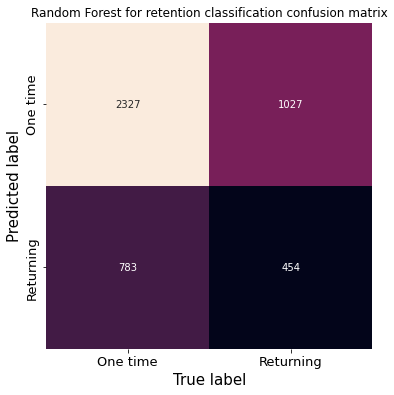

In [39]:
# Fit Random Forest with balanced class weights
rf_balanced = rf(class_weight = 'balanced', random_state = 527).fit(x_train, y_train)
# Predict
rf_balanced_pred = rf_balanced.predict(x_test)
rf_acc_score = accuracy_score(y_test, rf_balanced_pred)
rf_pre_score = precision_score(y_test, rf_balanced_pred)

# Confusion matrix and classification report
class_names = ['One time', 'Returning']
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_test, rf_balanced_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt = "d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.title('Random Forest for retention classification confusion matrix')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print("Classification report: ")
print(classification_report(y_test, rf_balanced_pred))

C:\Users\tuana\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report: 
              precision    recall  f1-score   support

           0       0.72      0.54      0.62      3110
           1       0.37      0.56      0.44      1481

    accuracy                           0.55      4591
   macro avg       0.54      0.55      0.53      4591
weighted avg       0.61      0.55      0.56      4591



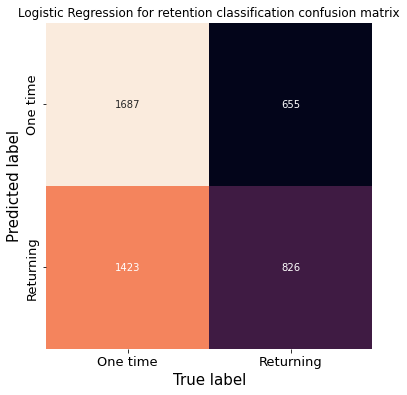

In [40]:
# Fit Logistic Reg with balanced class weights
lg_balanced = LogisticRegression(class_weight = 'balanced', random_state = 527).fit(x_train, y_train)
# Predict
lg_balanced_pred = lg_balanced.predict(x_test)

lg_acc_score = accuracy_score(y_test, lg_balanced_pred)
lg_pre_score = precision_score(y_test, lg_balanced_pred)
# Confusion matrix and classification report
class_names = ['One time', 'Returning']
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test, lg_balanced_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt = "d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.title('Logistic Regression for retention classification confusion matrix')

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print("Classification report: ")
print(classification_report(y_test, lg_balanced_pred))

Classification report: 
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      3110
           1       0.48      0.02      0.04      1481

    accuracy                           0.68      4591
   macro avg       0.58      0.50      0.42      4591
weighted avg       0.61      0.68      0.56      4591



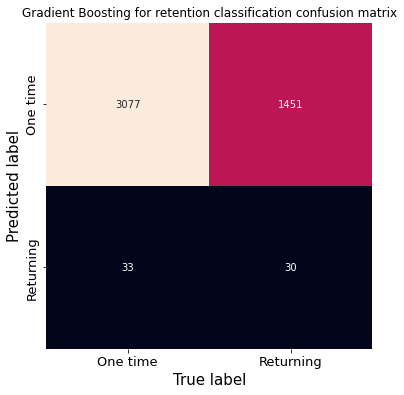

In [41]:
# Fit Gradient Boosting with balanced class weights
gb = GBC(random_state = 527).fit(x_train, y_train)
# Predict
gb_pred = gb.predict(x_test)

gb_acc_score = accuracy_score(y_test, gb_pred)
gb_pre_score = precision_score(y_test, gb_pred)
# Confusion matrix and classification report
class_names = ['One time', 'Returning']
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test, gb_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt = "d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.title('Gradient Boosting for retention classification confusion matrix')

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print("Classification report: ")
print(classification_report(y_test, gb_pred))

In [42]:
from xgboost import XGBClassifier as Xgb

# Fit Gradient Boosting with balanced class weights
xgb = Xgb(random_state = 527).fit(x_train, y_train)
# Predict
xgb_pred = xgb.predict(x_test)

xgb_acc_score = accuracy_score(y_test, xgb_pred)
xgb_pre_score = precision_score(y_test, xgb_pred)
# Confusion matrix and classification report
class_names = ['One time', 'Returning']
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test, xgb_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt = "d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.title('XG Boosting for retention classification confusion matrix')

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print("Classification report: ")
print(classification_report(y_test, xgb_pred))

KeyboardInterrupt: 

In [ ]:
# Add some more metric
rf_f1_score = f1_score(y_test, rf_balanced_pred)
lg_f1_score = f1_score(y_test, lg_balanced_pred)
xgb_f1_score = f1_score(y_test, xgb_pred)
gb_f1_score = f1_score(y_test, gb_pred)


metric_sum = pd.DataFrame({'Accuracy': [rf_acc_score,lg_acc_score,gb_acc_score,xgb_acc_score],\
                           'Precision': [rf_pre_score,lg_pre_score,gb_pre_score,xgb_pre_score],\
                          'F1 Score': [rf_f1_score,lg_f1_score,gb_f1_score,xgb_f1_score]},\
                         index = ['Random Forest', 'Logistic Regression', 'Gradient Boost', 'XG Boost'])

metric_sum.sort_values('F1 Score', ascending = False)

Even though XG Boost and Gradient Boost return higher accuracy and Precision, their F1 Score is significantly lower than Random FOrest and Logistic Regression, meaning that the false negative and false positive rate are higher and those models tends to be bias toward the negative group.
However, Logistic Regression and Random Forest returns an overall accuracy just higher than random binary guess around 5 to 10%, not to reliable. THe report will fine tune these 2 models to see if there are any improvements.

In [ ]:
# Fine tune Random Forest
np.random.seed(1)

grid_params = {'n_estimators': list(range(100,1001,100))
              ,'max_depth': [3, 5, 10, 15]
              , 'max_features': ['sqrt']
              , 'min_samples_split': [2, 5, 10]
              }

# Define Model
rfbalance = rf(class_weight = 'balanced')
# Define CV Run
gridcvbase = GridSearchCV(rfbalance, param_grid = grid_params, cv = 5)
# Run CV
gridcvbase.fit(x, y)

print('Best Parameters: ',gridcvbase.best_params_)
print('Lowest cross-validation error rate: {:.2f}%'.format(1 - gridcvbase.best_score_))


In [ ]:
# Fine tune Logistic regression
np.random.seed(1)

grid_params = {
    'C': [0.1, 1.0, 10.0, 100.0],          # Inverse of regularization strength (smaller values indicate stronger regularization), not cost.
    'max_iter': [100, 200, 500],           # Maximum number of iterations
}
# Define Model
lg = LogisticRegression(class_weight = 'balanced')
# Define CV Run
gridcvbase = GridSearchCV(lg, param_grid = grid_params, cv = 5)
# Run CV
gridcvbase.fit(x, y)

print('Best Parameters for Logistic Regression: ',gridcvbase.best_params_)
print('Lowest cross-validation error rate: {:.2f}%'.format(1 - gridcvbase.best_score_))


In [ ]:
# apply hyperparameters to RF
rf_best = rf(class_weight = 'balanced', max_depth= 15, min_samples_split=  2, n_estimators= 200).fit(x_train, y_train)
rf_best_pred = rf_best.predict(x_test)

# Confusion matrix and classification report
class_names = ['One time', 'Returning']
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test, rf_best_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt = "d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.title('Random Forest for retention classification confusion matrix')

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print("Classification report: ")
print(classification_report(y_test, rf_best_pred))

In [ ]:
# apply hyperparameters to LG
lg_best = LogisticRegression(class_weight = 'balanced', C= 0.1, max_iter=  500).fit(x_train, y_train)
lg_best_pred = lg_best.predict(x_test)

# Confusion matrix and classification report
class_names = ['One time', 'Returning']
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test, lg_best_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt = "d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.title('Random Forest for retention classification confusion matrix')

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print("Classification report: ")
print(classification_report(y_test, lg_best_pred))

After tuning hyperparameters of both Random Forest and Logistic Regression, there is no significant increase in performance. Using the model with higher F1 score, Logistic Regression, the prediction is only 55% accurate for unseen data,and is not reliable to draw any conclusion. There is no real strong indicators to predict customer retention only based on their purchase details and cart items. 

#### Importance of parameters to predict 

In [ ]:
importance_rf = pd.DataFrame({'Features':x_train.columns, "Importance": rf_best.feature_importances_}).sort_values(by = 'Importance', ascending= True)

plt.figure(figsize = (6,18))
plt.barh(importance_rf['Features'], importance_rf['Importance'])
plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)
plt.tick_params(labelsize = 14);

plt.show()

In [ ]:
# Importance of variables in explaining the decisions
importance_rf = pd.DataFrame({'Features':x_train.columns, "Importance": rf_best.feature_importances_})[:10].sort_values(by = 'Importance', ascending= False)
plt.figure(figsize = (18,6))
plt.plot(importance_rf['Features'], importance_rf['Importance'].cumsum())